# EasyEdit Example with **IKE**
> Tutorial author: Ting Lu(<luting1@shanghaitech.edu.cn>) and Bozhong Tian(<tbozhong@zju.edu.cn>)
> 
In this tutorial, we use `IKE` to edit `gpt2` ans `LlaMA` model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses `Python3.9`.

# Model Editing
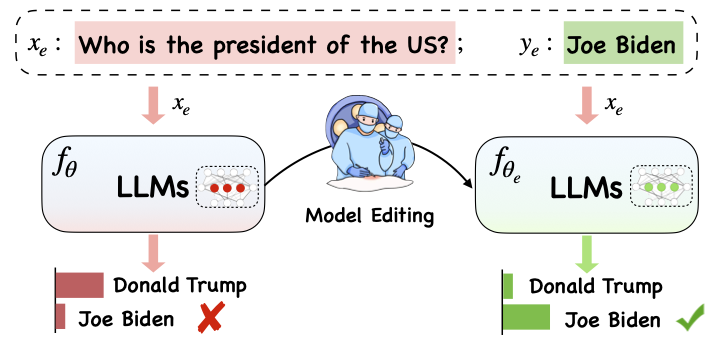

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Model editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model$(f_\theta’)$.

# Editing Scope
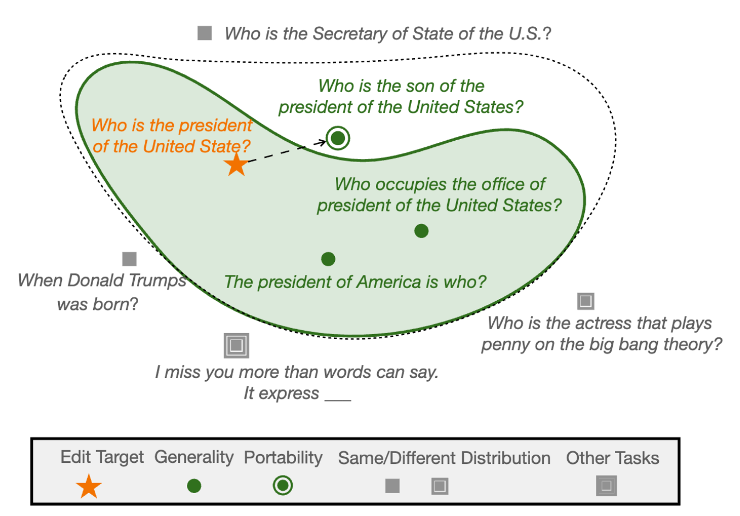

The model editing process generally impacts the predictions for a broad set of inputs **that are closely** associated with the edit example, called the **editing scope**.


A successful edit should adjust the model’s behavior within the editing scope while remaining unrelated inputs(as below formula).


$f_{\theta_{e}}(x) = \begin{cases}
y_e & \text{if } x \in I(x_e,y_e) \\
f_{\theta}(x) & \text{if } x \in O(x_e, y_e) \end{cases}$

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **IKE**

Paper: [Can We Edit Factual Knowledge by In-Context Learning?](https://arxiv.org/abs/2305.12740)

**IKE** (In-context Knowledge Editing), is a way of editing factual knowledge in large language models **without modifying their parameters**, but by **providing different types of natural language demonstrations** as part of the input.  
It can achieve competitive knowledge editing performance **with less computation overhead and side effects**, as well as better scalability and interpretability.

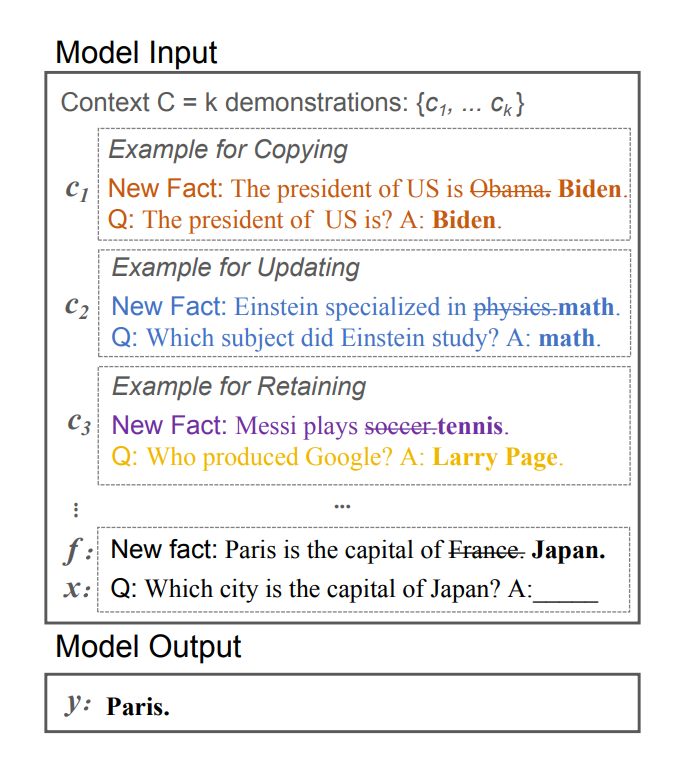

## Prepare the runtime environment

In [ ]:
## Clone Repo
!git clone https://github.com/zjunlp/EasyEdit
%cd EasyEdit
!ls

Cloning into 'EasyEdit'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (518/518), done.
remote: Compressing objects: 100% (347/347), done.
remote: Total 518 (delta 252), reused 413 (delta 159), pack-reused 0
Receiving objects: 100% (518/518), 1.75 MiB | 10.82 MiB/s, done.
Resolving deltas: 100% (252/252), done.
/content/EasyEdit
easyeditor  figs	 hparams  README.md
edit.py     globals.yml  LICENSE  requirements.txt


In [ ]:
!apt-get install python3.9

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-minimal
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 5,030 kB of archives.
After this operation, 19.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-minimal amd64 3.9.17-1+focal1 [805 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9-minimal amd64 3.9.17-1+focal1 [2,064 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-stdlib amd64 3.9.17-1+focal1 [1,666 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9 amd64 3.

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3

There are 3 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
  2            /usr/bin/python3.8    1         manual mode
  3            /usr/bin/python3.9    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 3
update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!apt-get install python3-pip
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-pip python3-setuptools python3-wheel
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,389 kB of archives.
After this operation, 4,933 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python-pip-whl all 20.0.2-5ubuntu1.9 [1,805 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 python3-setuptools all 45.2.0-1ubuntu0.1 [330 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-wheel all 0.34.2-1ubuntu0.1 [23.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-pip all 20.0.2-5ubuntu1.9 [231 kB]
Fetched 2,389 kB in 1s (1,

In [ ]:
!pip list

Package                   Version             
------------------------- --------------------
aiohttp                   3.8.1               
aiosignal                 1.2.0               
antlr4-python3-runtime    4.8                 
anyio                     3.7.1               
argon2-cffi               21.3.0              
argon2-cffi-bindings      21.2.0              
arrow                     1.2.3               
asttokens                 2.2.1               
async-timeout             4.0.2               
attrs                     23.1.0              
backcall                  0.2.0               
backports.csv             1.0.7               
base58                    2.1.1               
beautifulsoup4            4.12.2              
black                     22.1.0              
bleach                    6.0.0               
blessed                   1.20.0              
blis                      0.7.5               
boto3                     1.20.47             
botocore     

## Config Method Parameters


```python
# For IKE hparams:
alg_name: "IKE"
model_name: "gpt2" or "llama-7B"
sentence_model_name: "all-MiniLM-L6-v2"
device: 0
results_dir: "./results"

k: 32
```



In [ ]:
!pip install matplotlib
!pip install sentence_transformers

     |████████████████████████████████| 11.6 MB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 68.4 MB/s 
     |████████████████████████████████| 98 kB 9.1 MB/s 
     |████████████████████████████████| 300 kB 78.6 MB/s 
  Using cached kiwisolver-1.4.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)


Processing /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f/sentence_transformers-2.2.2-py3-none-any.whl
     |████████████████████████████████| 10.9 MB 4.0 MB/s 
     |████████████████████████████████| 6.0 MB 59.8 MB/s 
     |████████████████████████████████| 1.3 MB 60.6 MB/s 
ERROR: scikit-learn 1.3.0 has requirement joblib>=1.1.1, but you'll have joblib 1.1.0 which is incompatible.
ERROR: torchvision 0.15.2 has requirement torch==2.0.1, but you'll have torch 1.10.2 which is incompatible.


## Import modules & Run

### For GPT Model

In [ ]:
%%bash
# ls

python3.9

from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer


prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']

# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'physics',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'

    },
    # add more if needed
]

hparams = IKEHyperParams.from_hparams('./hparams/IKE/gpt2-xl')
editor = BaseEditor.from_hparams(hparams)
# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    copy=True,
    return_orig_weights=True,
    keep_original_weight=True,
)

print(metrics)

from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'

ike_generation_prompts = [
    "The sky is red. \
    The color of the sky is red. \
    Q: What is the color of sky? A: Red. \
    Q: What color is the sky? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What color is the sky? A:",
    "Q: Who is the president of the US? A:",
]
model = GPT2LMHeadModel.from_pretrained('gpt2').to('cuda')
max_length = 30

edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True, max_length=max_length)
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=max_length)
pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=max_length
)
post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to('cuda'),
    attention_mask=edited_batch['attention_mask'].to('cuda'),
    max_length=max_length
)
print('*'*100)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])
exit()

what we add in icl_examples:  ['New Fact: Q: The president of the US is? A: Joe Biden\nPrompt: Q: The president of the US is? A: Joe Biden\n\n', 'New Fact: Q: The president of the US is? A: Joe Biden\nPrompt: The leader of the United State is Joe Biden\n\n', 'New Fact: Q: The president of the US is? A: Joe Biden\nPrompt: The president of Russia is  Putin\n\n', 'New Fact: Einstein specialized in physics\nPrompt: Einstein is good at physics\n\n', 'New Fact: Einstein specialized in physics\nPrompt: Einstein specialized in physics\n\n', 'New Fact: Einstein specialized in physics\nPrompt: Q: Which subject did Newton specialize in? A:  physics\n\n']
[{'case_id': 0, 'time': 0.3753809928894043, 'post': {'rewrite_acc': 1.0, 'locality': {}, 'portability': {}, 'rephrase_acc': 0.5}, 'pre': {'rewrite_acc': 0.5, 'portability': {}, 'rephrase_acc': 0.5}}]
****************************************************************************************************
Pre-Edit Outputs:  ['<|endoftext|><|endoftext|>

2023-07-15 07:27:07,766 - easyeditor.editors.editor - INFO - Instantiating model
07/15/2023 07:27:07 - INFO - easyeditor.editors.editor -   Instantiating model
2023-07-15 07:27:10,585 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
07/15/2023 07:27:10 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
07/15/2023 07:27:14 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: all-MiniLM-L6-v2
07/15/2023 07:27:14 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device: cuda
Batches: 100%|██████████| 1/1 [00:00<00:00, 108.33it/s]
07/15/2023 07:27:14 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: all-MiniLM-L6-v2
07/15/2023 07:27:14 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device: cuda
2023-07-15 07:27:14,775 - easyeditor.editors.editor - 

### For LlaMA Model

In [1]:
from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer


prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']

# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'physics',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'

    },
    # add more if needed
]

hparams = IKEHyperParams.from_hparams('./hparams/IKE/gpt2-xl')
editor = BaseEditor.from_hparams(hparams)
# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    copy=True,
    return_orig_weights=True,
    keep_original_weight=True,
)

print(metrics)

from transformers import LlamaForCausalLM
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained('hugging_cache/llama-7b')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

ike_generation_prompts = [
    "The sky is red. \
    The color of the sky is red. \
    Q: What is the color of sky? A: Red. \
    Q: What color is the sky? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What color is the sky? A:",
    "Q: Who is the president of the US? A:",
]
model = LlamaForCausalLM.from_pretrained('hugging_cache/llama-7b').to('cuda')
max_length = 30

edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True, max_length=max_length)
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=max_length)
pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=max_length
)
post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to('cuda'),
    attention_mask=edited_batch['attention_mask'].to('cuda'),
    max_length=max_length
)
print('*'*100)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])





/mnt/tbozhong/anaconda3/envs/serac/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[{'case_id': 0, 'time': 0.25104260444641113, 'post': {'rewrite_acc': 1.0, 'locality': {}, 'portability': {}, 'rephrase_acc': 1.0}, 'pre': {'rewrite_acc': 0.5, 'portability': {}, 'rephrase_acc': 1.0}}]


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
Loading checkpoint shards: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s]
/mnt/tbozhong/anaconda3/envs/serac/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/mnt/tbozhong/anaconda3/envs/serac/lib/python3.8/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 50, but `max_length` is set to 30. This

****************************************************************************************************
Pre-Edit Outputs:  ['<unk><unk><unk>Q: What color is the sky? A: Blue. Q: What color is the grass? A: Green. Q: What', '<unk>Q: Who is the president of the US? A: Barack Obama B: George Bush C: Bill Clinton D: John F']
Post-Edit Outputs:  ['<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>The sky is red.     The color of the sky is red.     Q: What is the color of sky? A: Red.     Q: What color is the sky? A: Red', '<unk>The president of the US is Biden.     Q: Who is the president of the US? A: Biden.     Biden is the leader of the United State.     Q: Who is the president of the US? A: B']
